In [1]:
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn import tree, linear_model, svm, ensemble, metrics
from matplotlib import pyplot as plt
import xgboost as xgb
import scipy
import numpy as np

import compare_y
import cross_validation_result as cvr
import ML_helper

%matplotlib inline

In [71]:
# load PSL linear and random results with prior rule
TRUTH_linear = "../psl/data/simulation/linear/seed0/cross_val_6fold/"
INFER_linear = "../psl/result/simulation/linear/with_prior/"
linear_df = cvr.cross_val_result(TRUTH_linear, INFER_linear)

# load PSL random results
TRUTH_random = "../psl/data/simulation/random/seed0/cross_val_6fold/"
INFER_random = "../psl/result/simulation/random/with_prior/"
random_df = cvr.cross_val_result(TRUTH_random, INFER_random)

print linear_df
print random_df

    val_mse  val_rho
0  0.073991      1.0
1  0.079113      1.0
2  0.071850      1.0
3  0.081870      1.0
4  0.075727      1.0
5  0.083476      1.0
    val_mse   val_rho
0  0.158518 -0.015764
1  0.166438 -0.011020
2  0.158295 -0.011584
3  0.168026  0.169772
4  0.162445  0.081709
5  0.178968 -0.024205


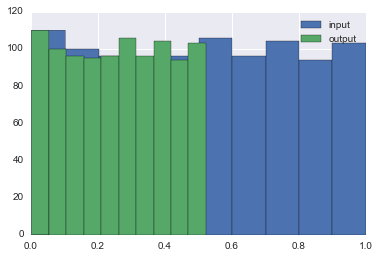

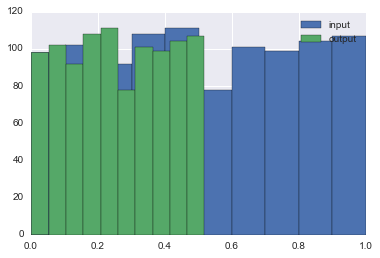

In [57]:
# plot input histogram and output histogram
plt.figure(1)
df1_in = compare_y.load_data(file_name="../psl/data/simulation/linear/sensitive_truth.txt")
df1_in.y.hist()
df1_out = compare_y.load_data(file_name="../psl/result/simulation/linear/fold1_result.txt")
df1_out.y.hist()
plt.legend(["input", "output"], loc="best")


plt.figure(2)
df2_in = compare_y.load_data(file_name="../psl/data/simulation/random/sensitive_truth.txt")
df2_in.y.hist()
df2_out = compare_y.load_data(file_name="../psl/result/simulation/random/fold1_result.txt")
df2_out.y.hist()
plt.legend(["input", "output"], loc="best")

In [72]:
# what if there is no prior in PSL rules?

TRUTH_linear = "../psl/data/simulation/linear/seed0/cross_val_6fold/"
INFER_linear = "../psl/result/simulation/linear/no_prior/"
linear_df = cvr.cross_val_result(TRUTH_linear, INFER_linear)

TRUTH_random = "../psl/data/simulation/random/seed0/cross_val_6fold/"
INFER_random = "../psl/result/simulation/random/no_prior/"
random_df = cvr.cross_val_result(TRUTH_random, INFER_random)

print linear_df
print random_df

        val_mse  val_rho
0  7.991461e-16      1.0
1  7.652288e-16      1.0
2  7.386355e-16      1.0
3  7.540871e-16      1.0
4  7.713779e-16      1.0
5  7.562180e-16      1.0
    val_mse   val_rho
0  0.165645 -0.015764
1  0.174145 -0.011020
2  0.162675 -0.011584
3  0.134763  0.169772
4  0.150627  0.081709
5  0.166939 -0.024205


In [2]:
Classifiers = {"Random Forest": ensemble.RandomForestRegressor(),
               "SVM": svm.SVR(kernel="rbf"), 
               "XGBoost": xgb.XGBRegressor(n_estimators=200),
               "Linear": linear_model.LinearRegression()}

In [63]:
X = np.random.rand(100,2)
Y = X[:,0]*2 + X[:,1]

# poly = preprocessing.PolynomialFeatures(2)
# X = poly.fit_transform(X)

mse, rho = ML_helper.run_cross_val(X, Y, Classifiers)

print mse
print rho

    XGBoost       SVM  Random Forest        Linear
1  0.008049  0.001425       0.017776  2.234079e-31
2  0.015357  0.003615       0.017460  5.103714e-32
3  0.004557  0.004605       0.007184  3.846082e-31
4  0.008939  0.004236       0.014117  1.020743e-32
5  0.006848  0.004287       0.012953  5.700753e-32
    XGBoost       SVM  Random Forest  Linear
1  0.982353  0.991176       0.944118     1.0
2  0.964706  1.000000       0.973456     1.0
3  0.982353  0.979412       0.973529     1.0
4  0.982353  1.000000       0.976471     1.0
5  0.985294  0.997059       0.976471     1.0


In [70]:
# run linear regression on simulated data

X1, linear_Y = ML_helper.load_data("../data/similuated_matrix_linear.tsv")
X2, random_Y = ML_helper.load_data("../data/similuated_matrix_random.tsv")

poly = preprocessing.PolynomialFeatures(2)
X1 = poly.fit_transform(X1)
X2 = poly.fit_transform(X2)

mse1, rho1 = ML_helper.run_cross_val(X1, linear_Y, Classifiers, n_fold=6)

print "linear"
print mse1
print rho1

mse2, rho2 = ML_helper.run_cross_val(X2, random_Y, Classifiers, n_fold=6)

print "\n random"
print mse2
print rho2

linear
    XGBoost       SVM  Random Forest        Linear
1  0.002574  0.064940       0.008540  2.493724e-30
2  0.002926  0.067794       0.010742  1.736232e-30
3  0.002594  0.055988       0.007820  2.057049e-30
4  0.002786  0.059313       0.005927  2.466419e-30
5  0.003105  0.057759       0.011025  2.276499e-30
6  0.002397  0.063065       0.005705  3.224397e-30
    XGBoost       SVM  Random Forest  Linear
1  0.987402  0.551249       0.956138     1.0
2  0.989021  0.479779       0.950568     1.0
3  0.989299  0.560370       0.944905     1.0
4  0.987138  0.606901       0.960861     1.0
5  0.986233  0.577159       0.932521     1.0
6  0.990248  0.581655       0.965559     1.0

 random
    XGBoost       SVM  Random Forest    Linear
1  0.086973  0.077487       0.090752  0.089826
2  0.089992  0.090276       0.100122  0.108167
3  0.104357  0.087211       0.090545  0.113125
4  0.095079  0.078028       0.090014  0.105462
5  0.091249  0.086187       0.095522  0.121354
6  0.091450  0.089958       0.